In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore',category=[UserWarning, FutureWarning])

### utils

In [171]:
def fill_na_with_rolling_window(data=None, col=None, series=None, n_step=None):
    if col:
        if isinstance(data,pd.DataFrame):
            data['n_roll'] = data[col].rolling(n_step).mean()
            data.loc[data[col].isna(), col] = data.loc[data[col].isna(),'n_roll']
            # display(data.loc[data[col].isna()])
            display(data['n_roll'].isna().sum())
        # elif isinstance(series,pd.Series):
        #     data['n_roll'] = data[col].rolling(n_step)
        #     data.loc[data[col].isna(),col] = data.loc[data[col].isna(),'n_roll']
        else: raise Exception("error")
    return data.drop('n_roll',axis=1)

# without scaling model did not perform so well, try scaling the features
def scale_features(df, name_of_features=[], type_of_features_to_scale=['float'], scaler=MinMaxScaler(), fit=True):
    scaler_map = {}
    if (len(name_of_features)==0) and type(name_of_features)==list:
        for col_no, pair in enumerate(df.dtypes.items()):
            if pair[1] in type_of_features_to_scale:
                # scaler expects df, so do iloc this way, else it will give a series
                if fit:
                    df.iloc[:,col_no:col_no+1] = scaler.fit_transform(df.iloc[:,col_no:col_no+1])
                else:
                    df.iloc[:,col_no:col_no+1] = scaler.transform(df.iloc[:,col_no:col_no+1])
                # scaler_map[pair[0]] = scaler
    else:
        for col_no, pair in enumerate(df.dtypes.items()):
            if pair[0] in name_of_features:
                # scaler expects df, so do iloc this way, else it will give a series
                if fit:
                    df.iloc[:,col_no:col_no+1] = scaler.fit_transform(df.iloc[:,col_no:col_no+1])
                else:
                    df.iloc[:,col_no:col_no+1] = scaler.transform(df.iloc[:,col_no:col_no+1])
                # scaler_map[pair[0]] = scaler
    return (df, scaler_map)



## Weather Forecasting

In [172]:
weather_data = pd.read_csv('data/spark_renewable_ds_forecast_challenge.csv', parse_dates=False)
weather_data.rename(columns={'TimeStamp (UTC)':'ts',
                             'WindDirection Avg':'wind_direction',
                             'WindSpeed Avg':'wind_speed_avg',
                             'WindSpeed StdDev':'wind_speed_std',
                             'T AMB Avg':'temp',
                             'In AirDensity Avg':'density'},inplace=True)

weather_data['ts'] = pd.to_datetime(weather_data['ts'],utc=True)
print(weather_data.shape)
weather_data.head()

(8760, 6)


,ts,wind_direction,wind_speed_avg,wind_speed_std,temp,density
0,2021-01-01 06:00:00+00:00,NaN,5.110103,NaN,-0.896897,NaN
1,2021-01-01 07:00:00+00:00,NaN,5.221429,NaN,-0.847589,NaN
2,2021-01-01 08:00:00+00:00,NaN,5.411667,NaN,-1.000000,NaN
3,2021-01-01 09:00:00+00:00,NaN,4.855000,NaN,-1.000000,NaN
4,2021-01-01 10:00:00+00:00,NaN,4.369630,NaN,-0.398102,NaN


In [173]:
weather_data.isna().sum(axis=0)

ts                   0
wind_direction    2192
wind_speed_avg      20
wind_speed_std     135
temp                20
density            291
dtype: int64

In [174]:
# checking for correlation
# sns.heatmap(weather_data.corr())

In [175]:
# checking time intervals in data
# (weather_data.ts - weather_data.ts.shift(1)).dt.total_seconds().unique()

In [176]:
# fill missing values in wind speed avg with spline interpolation (linear interpolation also does not show much difference from spline)
# plt.figure(figsize=(14,4))
# plt.plot(weather_data.wind_speed_avg.interpolate(option='linear').iloc[range(0,weather_data.shape[0],5)])
weather_data.interpolate(option='spline',inplace=True)
print("nan in wind speed",weather_data['wind_speed_avg'].isna().sum())

nan in wind speed 0


In [177]:
weather_data.isna().sum(axis=0)

ts                 0
wind_direction    19
wind_speed_avg     0
wind_speed_std    19
temp               0
density           19
dtype: int64

In [178]:
# still seeing nans, because interpolation did not fill nans at the start
# there is only 19 rows with nans now, which we drop because we have large enough data compared to 19 rows
# we can store persistence predictions here, so we do not miss out on one row when we take shift of column for it
persistence_predictions = weather_data.wind_speed_avg.shift(1)
weather_data.dropna(axis=0,inplace=True)

In [179]:
# plt.figure(figsize=(14,4))
# plt.plot(weather_data.set_index('ts').wind_speed_avg.rolling(80).mean(),zorder=13)
# plt.plot(weather_data.set_index('ts').wind_speed_avg)
# # plt.plot(weather_data.loc[~weather_data.wind_speed_avg.isna()].set_index('ts').wind_speed_avg,
# #             # weather_data.loc[~weather_data.wind_speed_avg.isna()]['ts'],
# #             c='blue',alpha=0.3,zorder=49)

# # plt.scatter( temp.loc[weather_data['wind_speed_avg'].isna()]['ts'],
# #     temp.loc[weather_data['wind_speed_avg'].isna()].set_index('ts').wind_speed_avg, 
# #     c='magenta',alpha=1,zorder=1, s=100)
# plt.show()
# plt.close()

In [180]:
# # check if nans occuring are together, also see if any observable patterns for wind speed and other
# fig,ax = plt.subplots(weather_data.shape[1]-1,1,figsize=(10,5),sharex=True)
# scaler = MinMaxScaler()
# for i,col in enumerate(weather_data.columns[1:]):
#     ax[i].plot(scaler.fit_transform(weather_data[col].values.reshape(-1,1)))
#     ax[i].set_title(col,size=10)

In [181]:
# # check trend, seasonality
# result = seasonal_decompose(weather_data.set_index('ts')['wind_speed_avg'].fillna(weather_data['wind_speed_avg'].mean()), 
#                             model='multiplicative', extrapolate_trend='freq')
# result.plot()
# plt.suptitle('Seasonal Decomposition of Air Passengers Time Series')
# plt.tight_layout()
# plt.show()
# plt.close()


[]

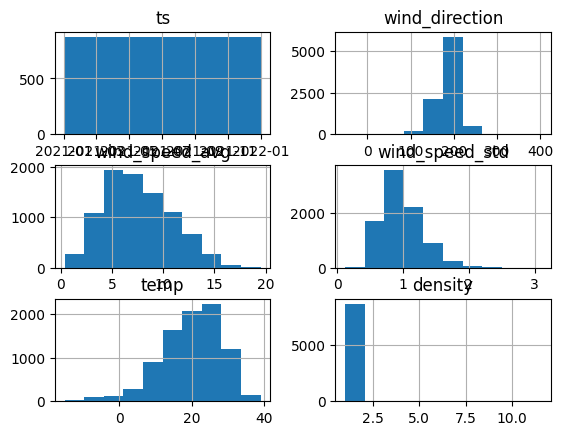

In [182]:
weather_data.hist()
plt.plot()

In [183]:
def add_lag_features(df,col_name,timestep):
    timestep_features = []
    for i in range(1,timestep+1):
        df[f'{i}_lag_{col_name}'] = df[col_name].shift(i)
        timestep_features.append(f'{i}_lag_{col_name}')
    return df, timestep_features

n1=48
weather_data, lag_speed_features = add_lag_features(weather_data, 'wind_speed_avg', n1)
n2=3
weather_data, lag_temp_features = add_lag_features(weather_data, 'temp', n2)
weather_data, lag_density_features = add_lag_features(weather_data, 'density', n2)
weather_data, lag_direction_features = add_lag_features(weather_data, 'wind_direction', n2)
weather_data, lag_wind_std_features = add_lag_features(weather_data, 'wind_speed_std',n2)
weather_data = weather_data.iloc[max(n1,n2):,:]

In [184]:
target_col = 'wind_speed_avg'
feature_list = []
feature_list.extend(lag_speed_features)
feature_list.extend(lag_temp_features)
feature_list.extend(lag_density_features)
feature_list.extend(lag_direction_features)

In [185]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.8)
# pca.fit(weather_data[feature_list])

# target_col_scaler = MinMaxScaler()
# target_col_scaler.fit_transform(weather_data[target_col].values.reshape(-1,1))

# weather_data, _ = scale_features(weather_data, name_of_features=feature_list, scaler=MinMaxScaler(), fit=True)

PCA(n_components=0.8)

In [186]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

model = RandomForestRegressor(n_estimators=50, max_depth=9,#int(0.7*(len(feature_list))), 
                              random_state=42, min_weight_fraction_leaf=0.001, 
                              min_samples_leaf=5, min_samples_split=40
                            )

x_train, x_test, y_train, y_test = train_test_split(weather_data[feature_list], weather_data[target_col], test_size=0.1, shuffle=False)
# PCA not improving things
# x_train = pca.transform(x_train)
# x_test = pca.transform(x_test)

# train_set, test_set = [x_train,y_train], [x_train,y_train]
train_set, test_set = [x_train,y_train], [x_test,y_test]

# test_set[1] = target_col_scaler.inverse_transform(test_set[1].values.reshape(-1,1))

model.fit(train_set[0], train_set[1])
predictions = model.predict(test_set[0])

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))

MAE 0.778512541274964
RMSE 1.0328299038882292


In [187]:
# persistence model's predictions
print("MAE",mean_absolute_error(test_set[1], persistence_predictions.loc[test_set[1].index]))
print("RMSE",root_mean_squared_error(test_set[1], persistence_predictions.loc[test_set[1].index]))

MAE 0.8482723981724137
RMSE 1.131327677786381


In [188]:
# pd.Series(model.feature_importances_,index=feature_list).nlargest(5).plot(kind='barh')

In [189]:
# import pickle
# # save
# with open('wind_forecast_model.pkl','wb') as f:
#     pickle.dump(model,f)

# # load
# import pickle
# with open('wind_forecast_model.pkl', 'rb') as f:
#     model = pickle.load(f)

# model.predict(X[0:1])

In [190]:
import xgboost as xg

# Train and test set are converted to DMatrix objects, 
# as it is required by learning API. 
train_dmatrix = xg.DMatrix(data = train_set[0], label = train_set[1]) 
test_dmatrix = xg.DMatrix(data = test_set[0], label = test_set[1]) 


param = {"booster":"gblinear", "objective":"reg:linear"} 
  
xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
predictions = xgb_r.predict(test_dmatrix) 

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))

Exception ignored on calling ctypes callback function: <function _log_callback at 0x16800db20>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/weather-forecast/lib/python3.12/site-packages/xgboost/core.py", line 158, in _log_callback
    warnings.warn(smsg, UserWarning)
TypeError: issubclass() arg 2 must be a class, a tuple of classes, or a union


MAE 1.5165518901017916
RMSE 1.8524269190614897


In [191]:
from sklearn.linear_model import LinearRegression, PassiveAggressiveRegressor

model = LinearRegression()

model.fit(train_set[0], train_set[1])
predictions = model.predict(test_set[0])

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))

MAE 0.7803662288331755
RMSE 1.034097501088809


In [192]:
awd

NameError: name 'awd' is not defined

In [22]:
# # causes kernel to crash for some reason
# import keras
# model = keras.Sequential()

# model.add(keras.layers.Dense(train_set[0].shape[1], input_shape=(train_set[0].shape[1],), activation='relu'))
# # model.add(keras.layers.Dense(100, activation='relu'))
# model.add(keras.layers.Dense(60, activation='relu'))
# model.add(keras.layers.Dense(1, activation='linear'))

# model.compile(loss='mean_squared_error',optimizer='adam')

# model.fit(train_set[0], train_set[1], epochs=100)
# # model.summary()
# predictions = model.predict(test_set[0],)

# # predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

# print("MAE",mean_absolute_error(test_set[1], predictions))
# print("RMSE",root_mean_squared_error(test_set[1], predictions))

## Anomaly Detection

In [ ]:
from sklearn.preprocessing import StandardScaler

In [54]:
time_series = pd.read_csv("data/anomaly_detection.csv")
time_series['date'] = pd.date_range(start='1/1/2016', end='30/12/2016')
print(time_series.shape)
time_series.head()

original_cols = ['CEACC','CCDEF','FAXAE','FBFFD','EDDAB']

(365, 6)


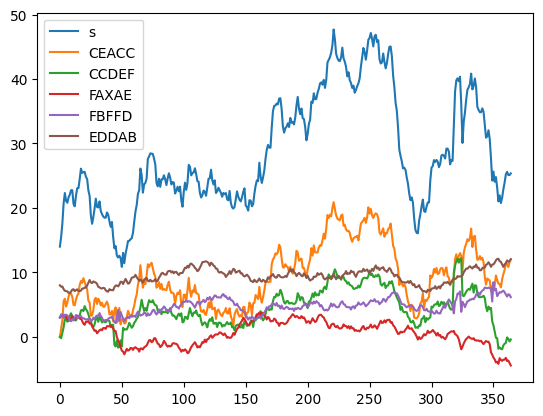

In [115]:
time_series['s'] = time_series[original_cols].sum(axis=1)
time_series.s.plot()
time_series.CEACC.plot()
time_series.CCDEF.plot()
time_series.FAXAE.plot()
time_series.FBFFD.plot()
time_series.EDDAB.plot()
plt.legend()
plt.show()
plt.close()

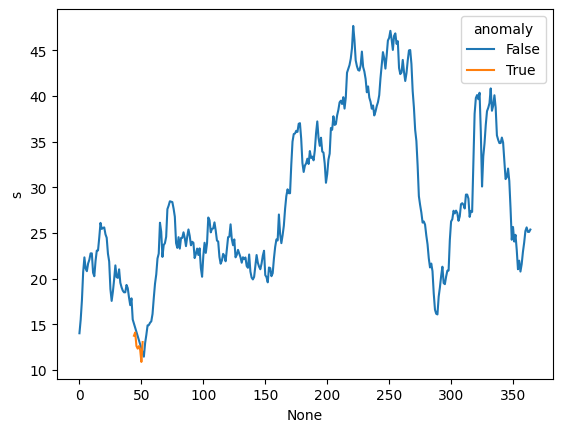

In [117]:
anomaly_start_doy, anomaly_end_doy = pd.to_datetime('2016-02-14').day_of_year, pd.to_datetime('2016-02-21').day_of_year

time_series['doy'] = time_series.date.dt.day_of_year
time_series['anomaly'] = False
time_series.loc[(time_series['doy']>=anomaly_start_doy) & (time_series['doy']<=anomaly_end_doy),'anomaly'] = True

sns.lineplot(data=time_series,y='s',x=time_series.index, hue='anomaly')
plt.show()
plt.close()

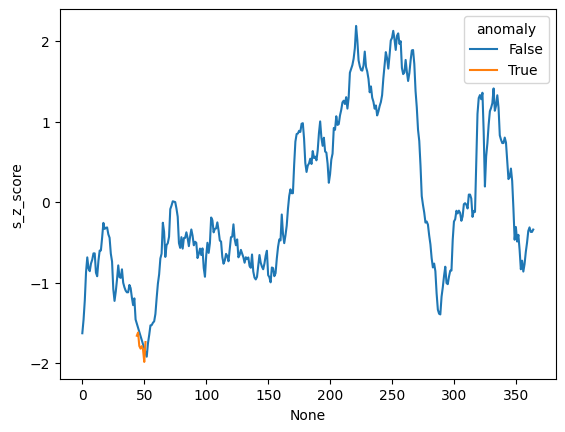

In [194]:
scaler = StandardScaler()
time_series['s_z_score'] = scaler.fit_transform(time_series['s'].values.reshape(-1,1))
sns.lineplot(data=time_series,y='s_z_score',x=time_series.index, hue='anomaly')
plt.show()
plt.close()